# Demonstrate the Aggregated Prediction Methods

In [1]:
import helper
import aggregated_predict as ap
import pandas as pd
import joblib
import time
import warnings
warnings.simplefilter('ignore')

## 1. Testing of each model and demonstration of model aggregated prediction methods

Client 1 Prediction Results:
-----------------------------
Accuracy : 0.9347735260144019
Precision: 0.9347996706659726
Recall   : 0.9347735260144019
F1 Score : 0.9347859184452929
-----------------------------

Client 2 Prediction Results:
-----------------------------
Accuracy : 0.9361743960284106
Precision: 0.9363809470733051
Recall   : 0.9361743960284106
F1 Score : 0.9362500307906552
-----------------------------

Client 3 Prediction Results:
-----------------------------
Accuracy : 0.934380299343803
Precision: 0.9343716179995314
Recall   : 0.934380299343803
F1 Score : 0.9343758739390926
-----------------------------

Server Prediction Results:
-----------------------------
Accuracy : 0.9974686033080193
Precision: 0.9974691856879152
Recall   : 0.9974686033080193
F1 Score : 0.9974687876789567
-----------------------------


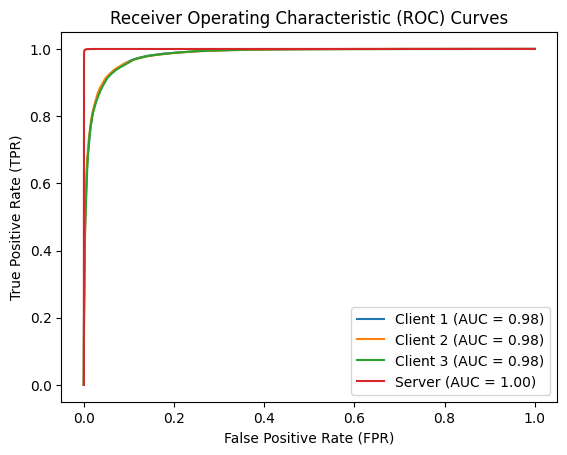

In [2]:
# Load the testing set
sensor_test, network_test = helper.load_test_set()

# Load the models
sensor_models = ['./received_models/client_1.joblib', './received_models/client_2.joblib', './received_models/client_3.joblib']
network_model = './received_models/global_model.joblib'

# Test models 
models_predictions, models_metrics = ap.get_predictions_and_metrics(
    local_models=sensor_models,
    sensor_test=sensor_test,
    global_model=network_model,
    network_test=network_test,
)

In [3]:
# Load network testing set, set the weights
y_test = network_test.iloc[:, -1]
model_weights = [0.2, 0.2, 0.2, 0.4]

In [4]:
print(f"Aggregated Prediction by Score:")
score = ap.aggregate_predict_by_score(
    models_predictions=models_predictions,
    models_metrics=models_metrics,
    models_weights=model_weights)
helper.get_metrics(y_test, score, printout=True)

Aggregated Prediction by Score:
-----------------------------
Accuracy : 0.9871464032047974
Precision: 0.9871689834992766
Recall   : 0.9871464032047974
F1 Score : 0.9871527519038
-----------------------------


(0.9871464032047974, 0.9871689834992766, 0.9871464032047974, 0.9871527519038)

In [5]:
print(f"Aggregated Prediction by Vote:")
vote = ap.aggregate_predict_by_vote(models_predictions=models_predictions)
helper.get_metrics(y_test, vote, printout=True)

Aggregated Prediction by Vote:
-----------------------------
Accuracy : 0.9721300597213006
Precision: 0.9739658171880584
Recall   : 0.9721300597213006
F1 Score : 0.9722821886803733
-----------------------------



(0.9721300597213006,
 0.9739658171880584,
 0.9721300597213006,
 0.9722821886803733)

## 2. Simulation of Intrusion Detection in Wireless Sensor Networks

Once the WSN simulation starts, the sensors in the nodes will collect new sensing data, these data need to pass the validation of the local models first. The data that passes the validation will be sent to the server and the data that does not pass will be discarded. Once the server receives the sensed data, it will validate the sensor data and the network traffic generated by the transmitted data by aggregated prediction method to give the final validation result. If the data passes the validation, the data is saved, otherwise, the data is discarded.

In [6]:
sensor_test['target'].value_counts()

target
0    24770
1    15919
Name: count, dtype: int64

In [7]:
# Select 10000 equally distributed samples from the testing set
s0 = sensor_test[sensor_test['target'] == 0].sample(10000)
s1 = sensor_test[sensor_test['target'] == 1].sample(10000)
sampled_sensor_data = pd.concat([s0, s1])
sampled_network_data = network_test.loc[sampled_sensor_data.index]

sampled_sensor_data = sampled_sensor_data.reset_index(drop=True)
sampled_network_data = sampled_network_data.reset_index(drop=True)

print(sampled_sensor_data['target'].value_counts())
print(sampled_network_data['target'].value_counts())

target
0    10000
1    10000
Name: count, dtype: int64
target
0    10000
1    10000
Name: count, dtype: int64


In [8]:
# Use Client 1 as an example
client_1_model = joblib.load('./received_models/client_1.joblib')
test_X = sampled_sensor_data.iloc[:, :-1]
test_y = sampled_sensor_data.iloc[:, -1]
client_1_predict = client_1_model.predict(test_X)
helper.get_metrics(test_y, client_1_predict, printout=True)

-----------------------------
Accuracy : 0.93205
Precision: 0.9324314434519547
Recall   : 0.93205
F1 Score : 0.9320350121909758
-----------------------------


(0.93205, 0.9324314434519547, 0.93205, 0.9320350121909758)

In [9]:
client_1_predict_df = pd.DataFrame(client_1_predict, columns=['Pred'])
client_1_predict_df['Pred'].value_counts()

Pred
0    10297
1     9703
Name: count, dtype: int64

In [10]:
# Client 1 will test the sensor data locally, only those that pass will be sent to the server
# Drop false data, target = 1
rows_to_keep = client_1_predict_df['Pred'] == 0
filtered_sensor_data = sampled_sensor_data[rows_to_keep]
filtered_network_data = sampled_network_data[rows_to_keep]

print(filtered_sensor_data['target'].value_counts())
print(filtered_network_data['target'].value_counts())

target
0    9469
1     828
Name: count, dtype: int64
target
0    9469
1     828
Name: count, dtype: int64


Client 1 Prediction Results:
-----------------------------
Accuracy : 0.9195882295814315
Precision: 0.8456425119847115
Recall   : 0.9195882295814315
F1 Score : 0.8810665735006146
-----------------------------

Client 2 Prediction Results:
-----------------------------
Accuracy : 0.9393027095270468
Precision: 0.940845224718667
Recall   : 0.9393027095270468
F1 Score : 0.9400332982881279
-----------------------------

Client 3 Prediction Results:
-----------------------------
Accuracy : 0.9423132951345052
Precision: 0.9432197318954446
Recall   : 0.9423132951345052
F1 Score : 0.9427501675207736
-----------------------------

Server Prediction Results:
-----------------------------
Accuracy : 0.9976692240458386
Precision: 0.997719203134149
Recall   : 0.9976692240458386
F1 Score : 0.9976818987821903
-----------------------------


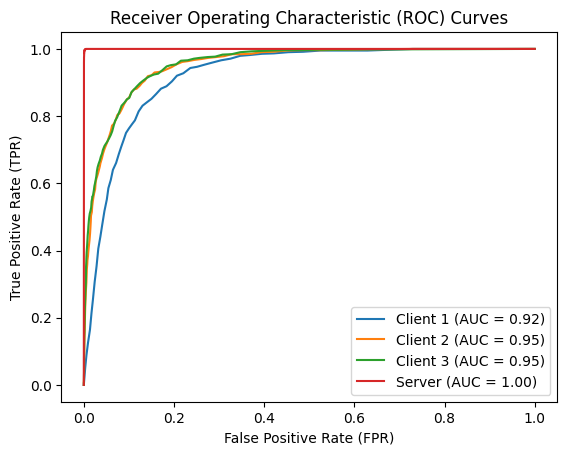

In [11]:
# Test Client 1 data using all models
new_models_predictions, new_models_metrics = ap.get_predictions_and_metrics(
    local_models=sensor_models,
    sensor_test=filtered_sensor_data,
    global_model=network_model,
    network_test=filtered_network_data,
)

In [12]:
# Load Client 1 network testing set
new_y_test = filtered_network_data.iloc[:, -1]

In [13]:
print(f"Client 1 Aggregated Prediction by Score:")
start_time = time.time()

new_score = ap.aggregate_predict_by_score(
    models_predictions=new_models_predictions,
    models_metrics=new_models_metrics,
    models_weights=model_weights)

end_time = time.time()
rows = len(new_models_predictions[0])
time_spend = end_time - start_time

helper.get_metrics(new_y_test, new_score, printout=True)
print(f"Time spent predicting {rows} pieces of data: {time_spend} second, average time spent: {time_spend / rows} seconds.")

Client 1 Aggregated Prediction by Score:
-----------------------------
Accuracy : 0.9867922695930854
Precision: 0.9868922134214333
Recall   : 0.9867922695930854
F1 Score : 0.9862834014159648
-----------------------------


Time spent predicting 10297 pieces of data: 0.0 second, average time spent: 0.0 seconds.


In [14]:
print(f"Client 1 Aggregated Prediction by Vote:")
start_time = time.time()

new_vote = ap.aggregate_predict_by_vote(models_predictions=new_models_predictions)

end_time = time.time()
time_spend = end_time - start_time

helper.get_metrics(new_y_test, new_vote, printout=True)
print(f"Time spent predicting {rows} pieces of data: {time_spend} second, average time spent: {time_spend / rows} seconds.")

Client 1 Aggregated Prediction by Vote:
-----------------------------
Accuracy : 0.9884432358939497
Precision: 0.9898265227028796
Recall   : 0.9884432358939497
F1 Score : 0.9887831522120221
-----------------------------


Time spent predicting 10297 pieces of data: 0.0060007572174072266 second, average time spent: 5.827675262122198e-07 seconds.
